In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import fairseq
from models.wav2vec_u import Wav2vec_U as w2vu
from models.testbench import Wav2vec_U as w2vuindy
import torch.nn.functional as F
import math
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
val_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.npy")

In [100]:
with open("/home/santiago.cuervo/ssl/nanoGPT/data/wiki40b_phn/en/input.txt", "r") as f:
    wiki_transcripts = f.readlines()

In [101]:
wiki_transcripts

['<SIL> P AY N EY S ER S EY N IY HH IH S T ER IY <SIL> AA N <SIL> S EH V AH N <SIL> AA G AH S T <SIL> W AH N EY T <SIL> F AY V <SIL> Z IH R OW AH <SIL> P AA R T AH V <SIL> DH AH T EH R IH T AO R IY <SIL> AH V P AY N EY <SIL> S ER <SIL> S EY N IY W AA Z <SIL> D IH T AE CH T <SIL> AH N D M ER JH D <SIL> W IH DH <SIL> AH P AA R T AH V <SIL> DH AH T EH R IH T AO R IY AH V <SIL> D OY AH L L AA B EH R IY AH P AA R T AH V <SIL> DH AH T EH R IH T AO R IY AH V S EY N T <SIL> G R EY SH AH N <SIL> AH N D <SIL> AH <SIL> P AA R T <SIL> AH V <SIL> DH AH T EH R IH T AO R IY <SIL> AH V S OY S IY S UW Z M AA N T ER M AA N S IY T UW K R IY EY T DH AH K AA M Y UW N <SIL> AH V <SIL> EH NG HH IY N <SIL> L EH S <SIL> B EY N Z <SIL> F R AE N S AH S D UW K AH V S IY <SIL> D IH Z W AH N TH R IY M EY W AH N <SIL> EY T <SIL> T UW T UW <SIL> W AH N <SIL> S EH V AH N <SIL> EY P R AH L <SIL> W AH N N AY N <SIL> Z IH R OW T UW <SIL> K IH NG K AA N S AO R T <SIL> AH V S P EY N <SIL> T UH K <SIL> AH P R EH Z IH D AH N

In [99]:
phone_transcripts

['AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D\n',
 'AY G OW N AW L AO R D S EH D HH IY T UW M IY T DH AH N AY T AH N D T UW K AA N D AH K T HH IH M T UW HH IH Z L AA JH IH NG\n',
 'AH N D HH IY R AH S IY V D HH IH M AH N D DH AE T N AA T F IY B L IY\n',
 'AH N D HH IY D IH Z AY ER D IY N IH D T UW M AW N T HH ER HH AO R S AH N D T UW R AY D F AO R W ER D AH N D T UW K IY P AH L AO NG W EY B IH F AO R HH IH M\n',
 'B IH F AO R JH EH R AH N T DH AH S K ER JH AH V DH AH EH N AH M IY AY S AO S T IY D Z W AY T W IH DH F OW M AH N D AE F T ER DH AH SH AW T AH V B AE T AH L AH F IH R F AH L T AO R AH N T\n',
 'AH N D AE F T ER DH EY HH AE D IY T AH N AH N D D R AE NG K JH EH R AH N T W EH N T T UW S L IY P AH N D S OW D IH D IY N IH D AO L S OW\n',
 'B AH T W AH N P ER S AH N OW N L IY W IH L G OW W IH DH M IY\n',
 'M AY L AO R D HH IY AE D AH D W IH L IH T B IY D

In [3]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.tsv", "r") as f:
    lines = f.readlines()
audio_path = lines[0]
audio_ids = []
for audio_id in lines[1:]:
    audio_ids.append(audio_id.split('\t')[0].split('/')[1])
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.phn", "r") as f:
    phone_transcripts = f.readlines()
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [4]:
dataset = np.split(val_feats, np.cumsum(seq_lens)[:-1])

In [5]:
len(audio_ids), len(phone_transcripts), len(seq_lens), len(dataset)

(2864, 2864, 2864, 2864)

Text(0.5, 1.0, 'Wav2vec representations for sample 3660-172183-0024.wav')

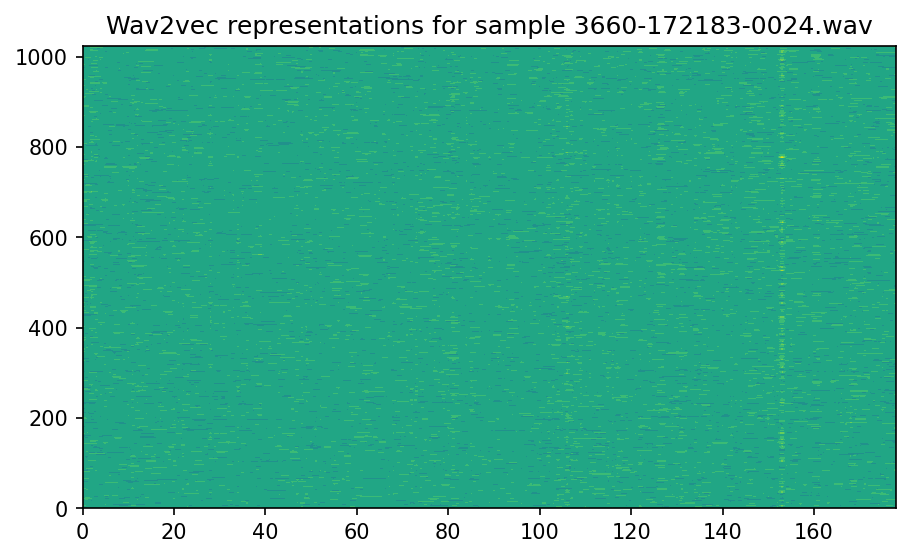

In [6]:
sample_idx = 1
x = np.arange(0, seq_lens[sample_idx])
y = np.arange(0, val_feats.shape[1])
X, Y = np.meshgrid(x, y)
Z = dataset[sample_idx].T
Z = Z / np.sqrt((Z**2).sum(1, keepdims=True))

plt.figure(figsize=(7, 4), dpi=150)
plt.contourf(X, Y, Z, 10)
plt.title(f"Wav2vec representations for sample {audio_ids[sample_idx]}")

In [7]:
cp = '/multirun/2023-05-07/12-23-39/0/w2v2_2023-05-07_12:21:11_0/checkpoint_12_2000.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
wav2phn = model[0]
wav2phn.eval()

Wav2vec_U(
  (discriminator): Discriminator(
    (net): Sequential(
      (0): Conv1d(44, 384, kernel_size=(8,), stride=(1,), padding=(7,))
      (1): SamePad()
      (2): Dropout(p=0.0, inplace=False)
      (3): Sequential(
        (0): Conv1d(384, 384, kernel_size=(8,), stride=(1,), padding=(7,))
        (1): SamePad()
        (2): Dropout(p=0.0, inplace=False)
        (3): GELU(approximate='none')
      )
      (4): Conv1d(384, 1, kernel_size=(8,), stride=(1,), padding=(7,))
      (5): SamePad()
    )
  )
  (segmenter): JoinSegmenter()
  (generator): Generator(
    (dropout): Dropout(p=0.1, inplace=False)
    (proj): Sequential(
      (0): TransposeLast()
      (1): Conv1d(1024, 44, kernel_size=(9,), stride=(3,), padding=(4,), bias=False)
      (2): TransposeLast()
    )
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (in_proj): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (decoder): Linear(in_features=1024, out_feature

In [78]:
cp = '/multirun/2023-05-05/22-24-16/0/w2v-indy-phn_en-phn_en_2023-05-05_22:24:05_0/checkpoint_best.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
wav2dyn = model[0]
wav2dyn.eval()

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 10.64M


Wav2vec_U(
  (segmenter): JoinSegmenter()
  (lm): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(40, 384)
      (wpe): Embedding(256, 384)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-5): 6 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=384, out_features=1152, bias=False)
            (c_proj): Linear(in_features=384, out_features=384, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=384, out_features=1536, bias=False)
            (c_proj): Linear(in_features=1536, out_features=384, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=384, out_features=40, bias=False)
  )
  (discriminat

# wav2phn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AW R AW D AE N D HH AE Z D DH AH K AH K T B IY CH HH AO Z JH UH N DH AH V IH V R AY R UH N D K AH N D DH UH N IY V AE Z W ER N AE D DH AH N S UW M AW D SH AH N AH D IH Y EY D K AH N D K AH K AH K S P AA


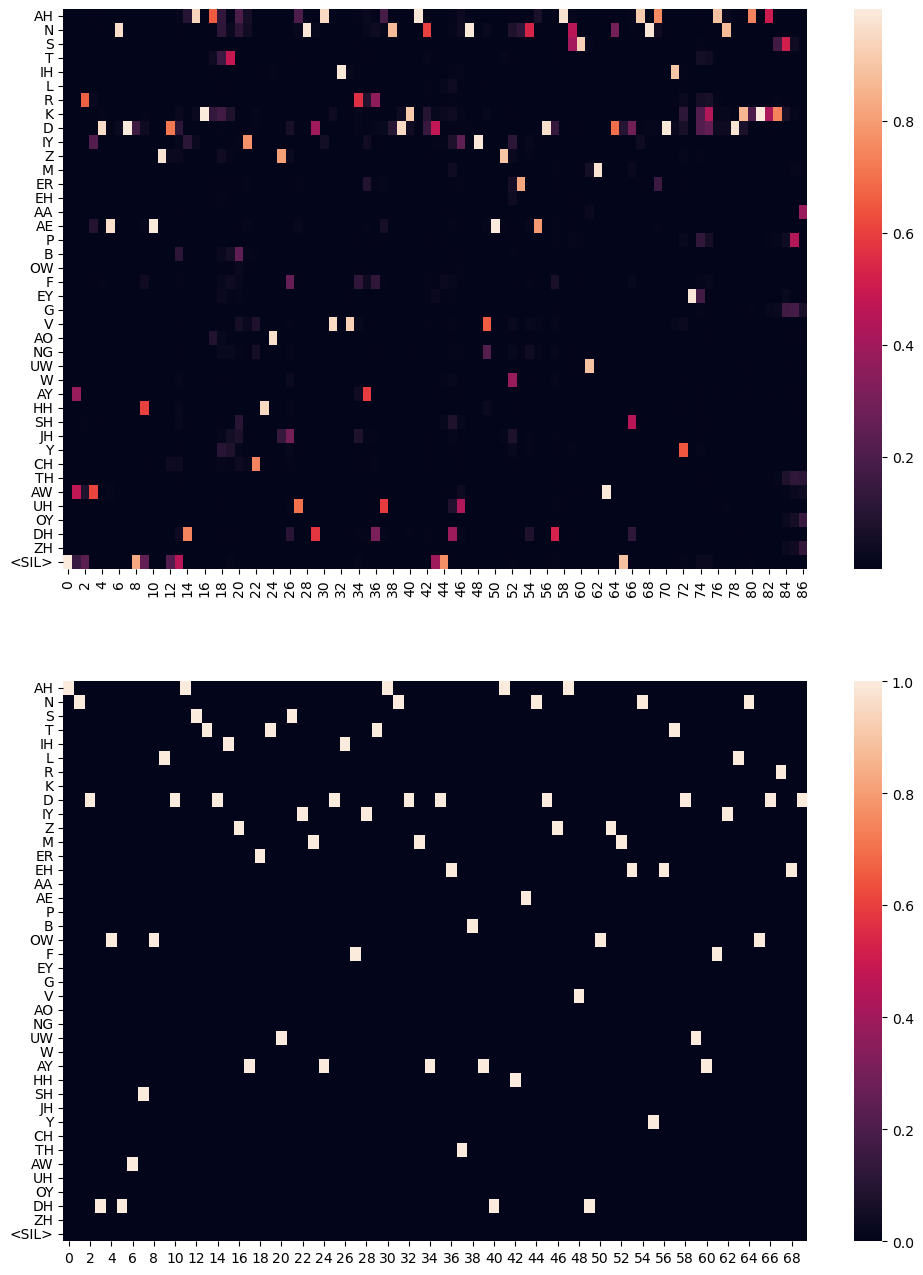

In [35]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2phn(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy().T
predicted_x = dense_x.argmax(0) + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long() - 4
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float().squeeze().detach().numpy().T
plt.figure(figsize=(12, 16))
plt.subplot(211)
sns.heatmap(dense_x, yticklabels=task.target_dictionary.symbols[4:])
plt.subplot(212)
sns.heatmap(token_x, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# wav2dyn outs

Utterance:
AH N D DH OW DH AW SH OW L D AH S T D IH Z AY ER T UW S IY M AY D IH F IY T AH N D M AY D EH TH B AY DH AH HH AE N D Z AH V DH OW Z M EH N Y EH T D UW AY F IY L N OW D R EH D

Predicted:
AY NG W AY DH EY HH DH EH Y UW L EH D HH AY L EH T IH Y UW G EH T DH NG T IH Y UW AH AO R AE T DH AH DH EY T IH P TH P EY IH T Y UW G EH T Y UW Y UW R


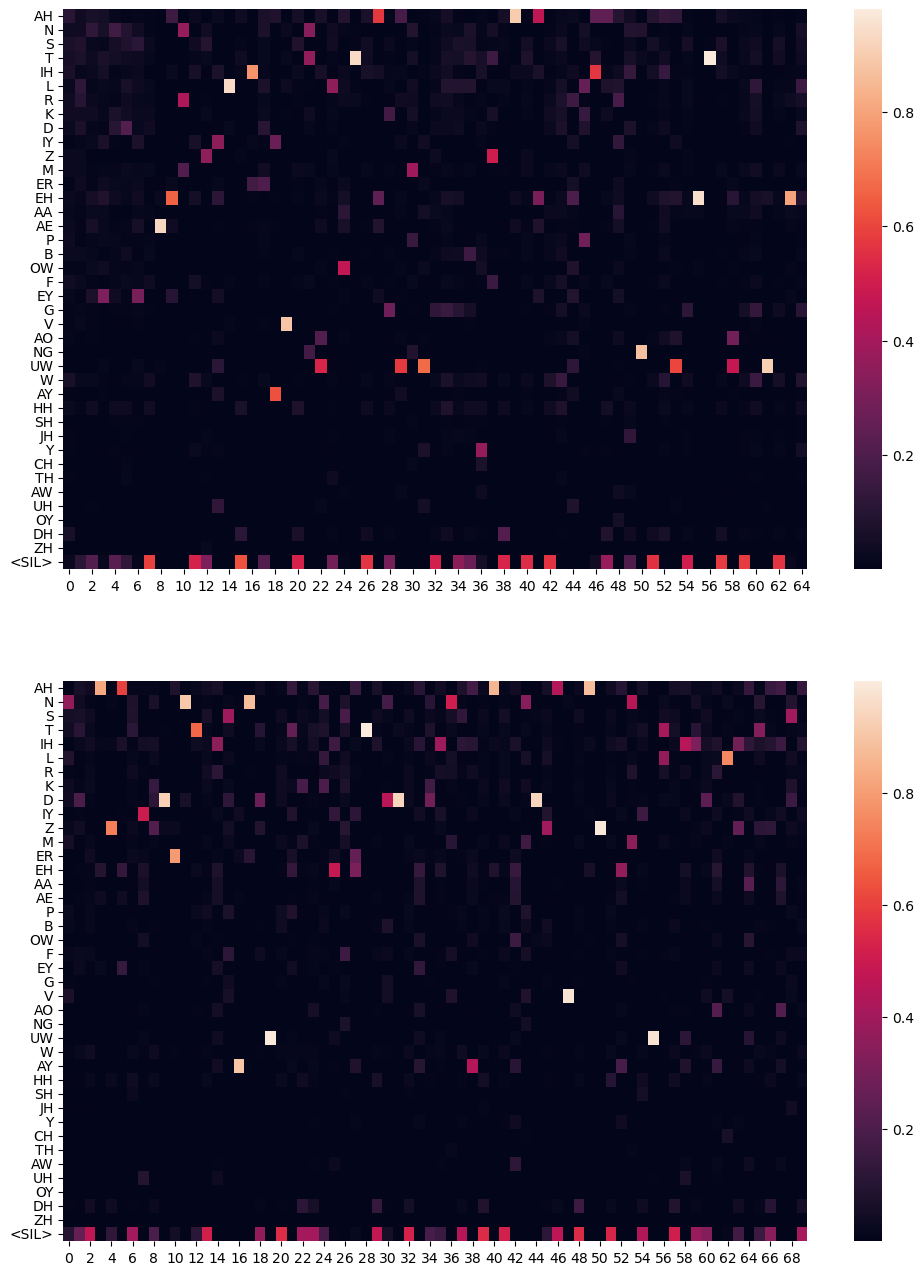

In [34]:
sample_idx = 0
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
dense_x = gen_result['logits'][:, :, 4:]
predicted_x = dense_x.argmax(-1) + 4
predicted_x = predicted_x[predicted_x != task.sil_id]
lm_post_gen = wav2dyn.lm(dense_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
token_x = task.target_dictionary.encode_line(phone_transcripts[sample_idx][:-1], append_eos=False).long() - 4
token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy().T
plt.figure(figsize=(12, 16))
plt.subplot(211)
sns.heatmap(lm_post_gen, yticklabels=task.target_dictionary.symbols[4:])
plt.subplot(212)
sns.heatmap(lm_post_true, yticklabels=task.target_dictionary.symbols[4:])
print(f"Utterance:\n{phone_transcripts[sample_idx]}")
print(f"Predicted:\n{task.target_dictionary.string(predicted_x)}")

# Collecting ground truth statistics on wiki40b

In [109]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in wiki_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus).replace('<SIL>', "")
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 6266820), ('N', 4825403), ('T', 3619099), ('IH', 3394388), ('R', 2962307), ('S', 2854374), ('D', 2162027), ('L', 2141331), ('K', 1834755), ('IY', 1773248)]


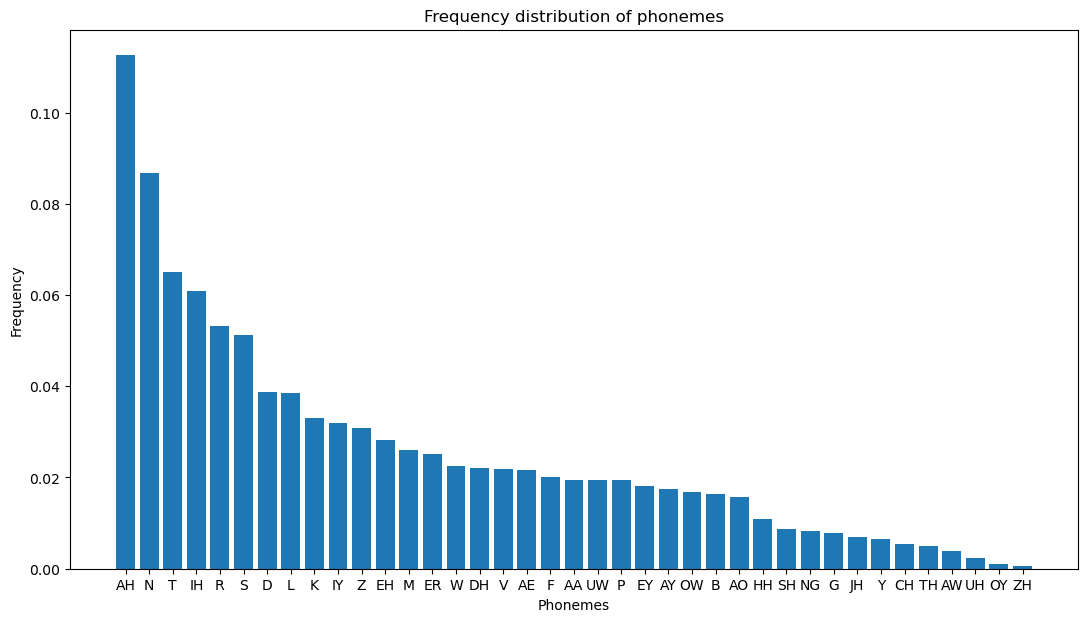

In [110]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting ground truth stats on val set

## Unigrams

In [127]:
from collections import Counter
import re

# Remove newline characters from each string
corpus = [sentence.strip() for sentence in phone_transcripts]
# Concatenate all the strings in the list into a single string
text = ' '.join(corpus)
# Tokenize the string into individual phonemes using regular expressions
tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
# Calculate the frequency distribution of the phonemes
freq_dist = Counter(tokens)
# Print the 10 most common phonemes in the corpus
print(freq_dist.most_common(10))

[('AH', 17549), ('N', 12816), ('T', 12657), ('IH', 10532), ('D', 9316), ('S', 8822), ('R', 7659), ('L', 7019), ('IY', 6298), ('DH', 5663)]


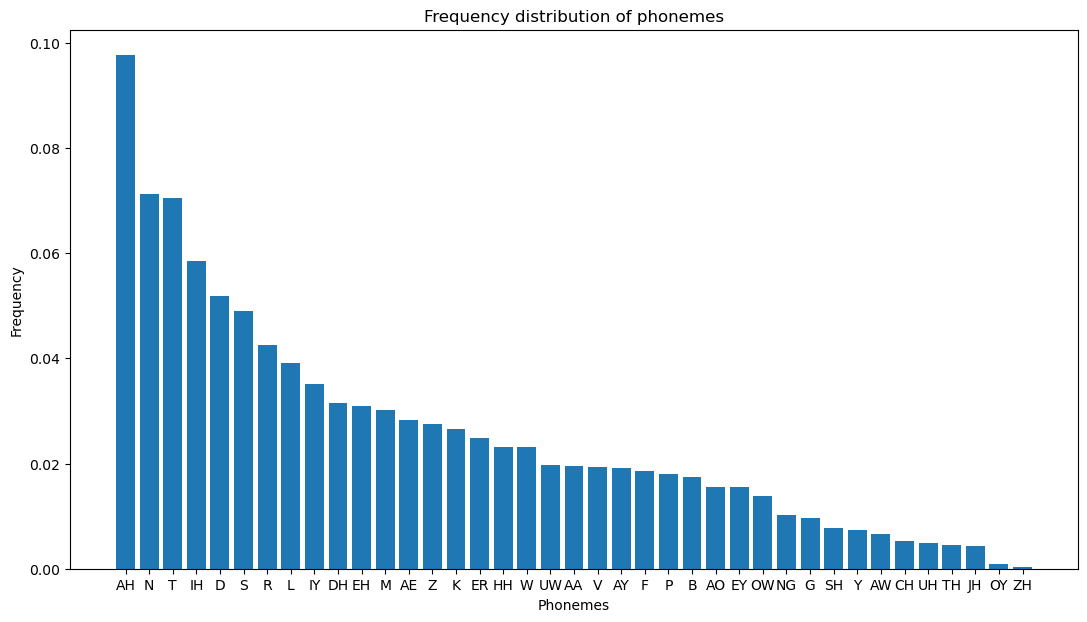

In [128]:
# Sort the frequency distribution in descending order of frequency
sorted_freq_dist = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
# Extract the phoneme labels and frequencies into separate lists
labels, frequencies = zip(*sorted_freq_dist)
# Create a bar chart of the frequency distribution of all phonemes
plt.figure(figsize=(13, 7))
plt.bar(labels, frequencies / np.sum(frequencies))
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## LM n-grams

In [126]:
posteriograms = []

for transcript in tqdm(phone_transcripts):
    token_x = task.target_dictionary.encode_line(transcript[:-1], append_eos=False).long() - 4
    token_x = F.one_hot(token_x, num_classes=len(task.target_dictionary.symbols) - 4).unsqueeze(0).float()
    lm_post_true = wav2dyn.lm(token_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy()
    posteriograms.append(lm_post_true)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [129]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
syms = task.target_dictionary.symbols[4:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

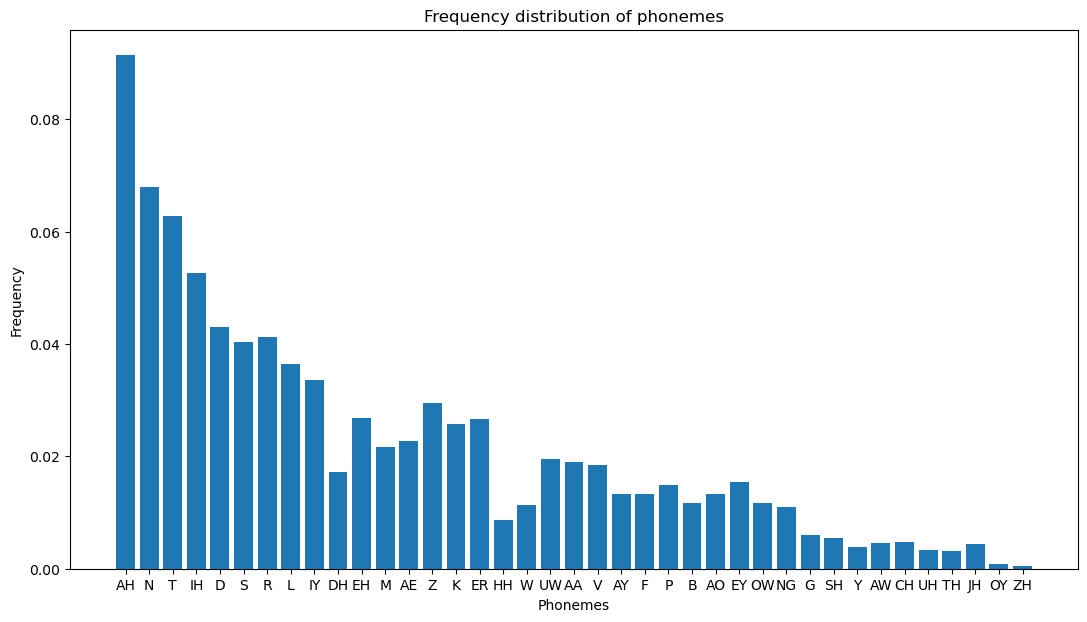

In [130]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on wav2phn after 2000 updates

In [85]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2phn(x, padding_mask, dense_x_only=True)
    dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [89]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
syms = task.target_dictionary.symbols[4:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

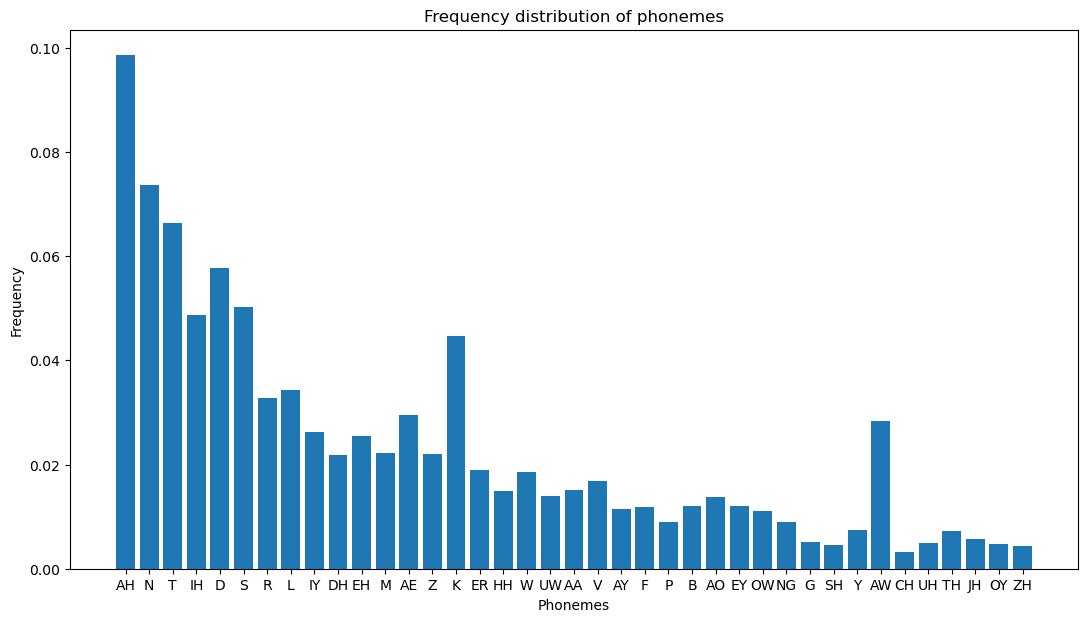

In [90]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

# Collecting stats on best wav2dyn after whole training

## On unigram posteriograms

In [91]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
    dense_x = gen_result['logits'][:, :, 4:].squeeze().detach().numpy()
    posteriograms.append(dense_x)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [93]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
syms = task.target_dictionary.symbols[4:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

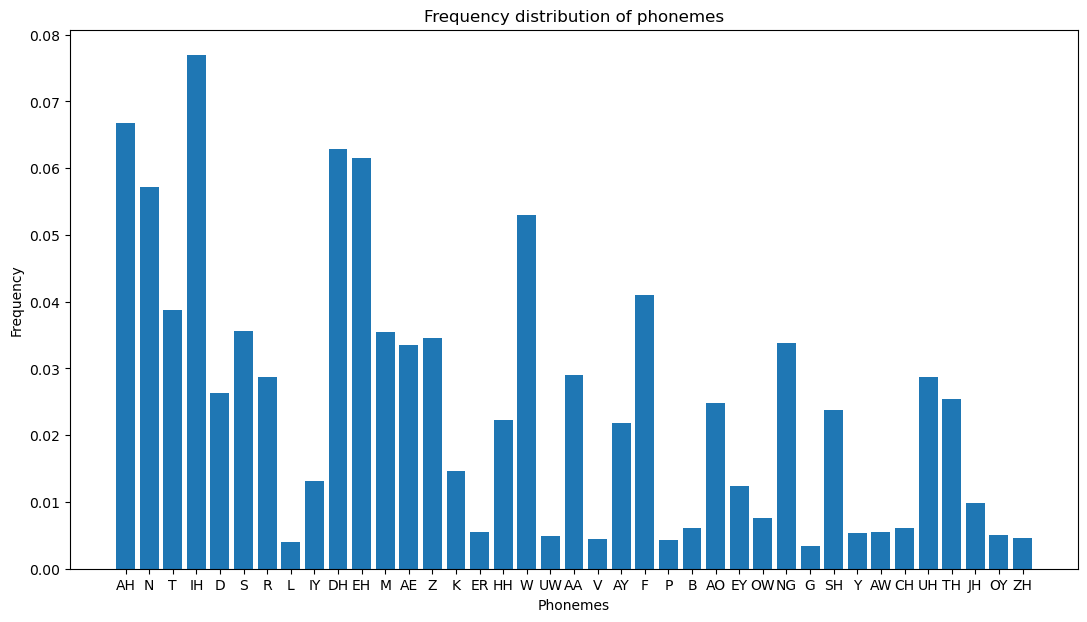

In [98]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()

## On LM n-gram posteriograms

In [131]:
posteriograms = []

for sample in tqdm(dataset):
    x = torch.FloatTensor(sample).unsqueeze(0)
    padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
    gen_result = wav2dyn(x, padding_mask, dense_x_only=True)
    dense_x = gen_result['logits'][:, :, 4:]
    lm_post_gen = wav2dyn.lm(dense_x[:, :wav2dyn.block_size, :]).squeeze().detach().numpy()
    posteriograms.append(lm_post_gen)

  0%|          | 0/2864 [00:00<?, ?it/s]

In [132]:
posteriograms = np.vstack(posteriograms)
unigram_probs = posteriograms.mean(0)[:-1]
syms = task.target_dictionary.symbols[4:-1]
freq_dist = {syms[i]: p for i, p in enumerate(unigram_probs)}
sorted_probs = [freq_dist[label] for label in labels]

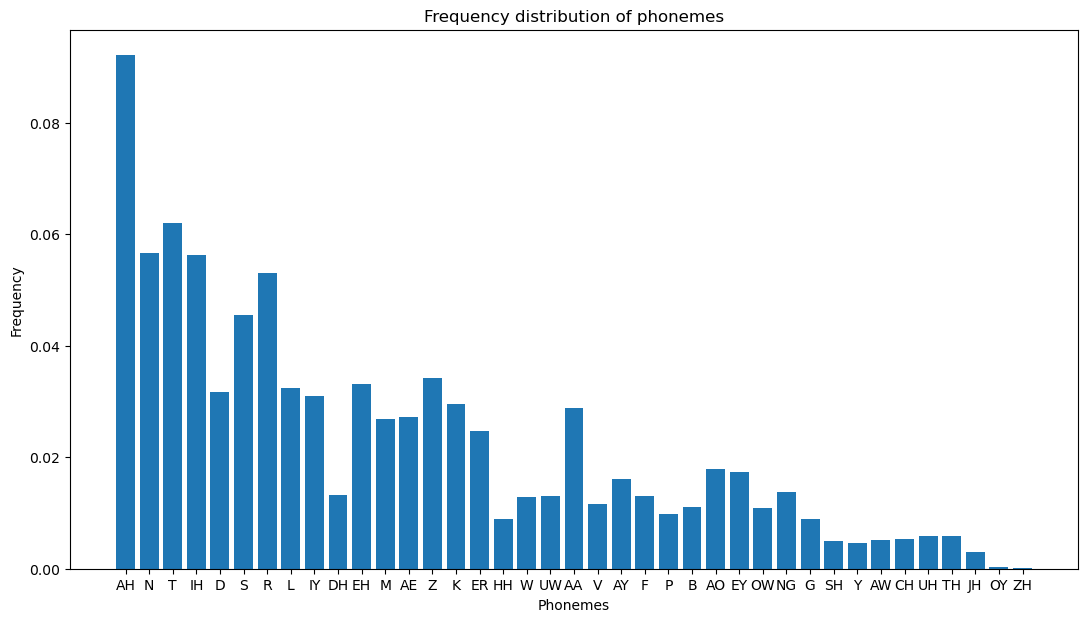

In [133]:
plt.figure(figsize=(13, 7))
plt.bar(labels, sorted_probs)
plt.title('Frequency distribution of phonemes')
plt.xlabel('Phonemes')
plt.ylabel('Frequency')
plt.show()